# Código del profe


In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Generador basado en ejemplo del curso CS231 de Stanford: 
# CS231n Convolutional Neural Networks for Visual Recognition
# (https://cs231n.github.io/neural-networks-case-study/)
def generar_datos_clasificacion(cantidad_ejemplos, cantidad_clases):
    FACTOR_ANGULO = 0.79
    AMPLITUD_ALEATORIEDAD = 0.1

    # Calculamos la cantidad de puntos por cada clase, asumiendo la misma cantidad para cada 
    # una (clases balanceadas)
    n = int(cantidad_ejemplos / cantidad_clases)

    # Entradas: 2 columnas (x1 y x2)
    x = np.zeros((cantidad_ejemplos, 2))
    
    # Salida deseada ("target"): 1 columna que contendra la clase correspondiente (codificada como un entero)
    t = np.zeros(cantidad_ejemplos, dtype="uint8")  # 1 columna: la clase correspondiente (t -> "target")
    
    randomgen = np.random.default_rng()

    # Por cada clase (que va de 0 a cantidad_clases)...
    for clase in range(cantidad_clases):
        # Tomando la ecuacion parametrica del circulo (x = r * cos(t), y = r * sin(t)), generamos 
        # radios distribuidos uniformemente entre 0 y 1 para la clase actual, y agregamos un poco de
        # aleatoriedad
        radios = np.linspace(0, 1, n) + AMPLITUD_ALEATORIEDAD * randomgen.standard_normal(size=n)

        # ... y angulos distribuidos tambien uniformemente, con un desfasaje por cada clase
        angulos = np.linspace(clase * np.pi * FACTOR_ANGULO, (clase + 1) * np.pi * FACTOR_ANGULO, n)

        # Generamos un rango con los subindices de cada punto de esta clase. Este rango se va
        # desplazando para cada clase: para la primera clase los indices estan en [0, n-1], para
        # la segunda clase estan en [n, (2 * n) - 1], etc.
        indices = range(clase * n, (clase + 1) * n)

        # Generamos las "entradas", los valores de las variables independientes. Las variables:
        # radios, angulos e indices tienen n elementos cada una, por lo que le estamos agregando
        # tambien n elementos a la variable x (que incorpora ambas entradas, x1 y x2)
        x1 = radios * np.sin(angulos)
        x2 = radios * np.cos(angulos)
        x[indices] = np.c_[x1, x2] #Esta función une al vector x1 y a x2. Es como que genera una matriz.

        # Guardamos el valor de la clase que le vamos a asociar a las entradas x1 y x2 que acabamos
        # de generar
        t[indices] = clase

    return x, t


def inicializar_pesos(n_entrada, n_capa_2, n_capa_3):
    randomgen = np.random.default_rng()

    #w son los pesos, b son los sesgos. En este caso tenemos 2 capas luego de la capa de entrada
    
    #Se inicializan con un valor bajo. Por eso se multiplilcan por 0.1
    w1 = 0.1 * randomgen.standard_normal((n_entrada, n_capa_2))
    b1 = 0.1 * randomgen.standard_normal((1, n_capa_2))

    w2 = 0.1 * randomgen.standard_normal((n_capa_2, n_capa_3))
    b2 = 0.1 * randomgen.standard_normal((1,n_capa_3))

    return {"w1": w1, "b1": b1, "w2": w2, "b2": b2}


def ejecutar_adelante(x, pesos):
    # Funcion de entrada (a.k.a. "regla de propagacion") para la primera capa oculta
    z = x.dot(pesos["w1"]) + pesos["b1"]
    #Por más que b1 sea un vector y la multiplicación de x*w sea una matriz, como tienen la misma cantidad de columnas, se puede hacer la suma porque numpy intuye que queremos sumar a cada fila de la matriz el mismo vector b.

    # Funcion de activacion ReLU para la capa oculta (h -> "hidden")
    h = np.maximum(0, z)
    #Esta función de activación convierte a 0 los valores negativos, y deja como está a los valores positivos.

    # Salida de la red (funcion de activacion lineal). Esto incluye la salida de todas
    # las neuronas y para todos los ejemplos proporcionados
    y = h.dot(pesos["w2"]) + pesos["b2"]

    return {"z": z, "h": h, "y": y}

#Esto se usaría una vez que la red neuronal ya está entrenada
def clasificar(x, pesos):
    # Corremos la red "hacia adelante"
    resultados_feed_forward = ejecutar_adelante(x, pesos)
    
    # Buscamos la(s) clase(s) con scores mas altos (en caso de que haya mas de una con 
    # el mismo score estas podrian ser varias). Dado que se puede ejecutar en batch (x 
    # podria contener varios ejemplos), buscamos los maximos a lo largo del axis=1 
    # (es decir, por filas)
    max_scores = np.argmax(resultados_feed_forward["y"], axis=1)

    # Tomamos el primero de los maximos (podria usarse otro criterio, como ser eleccion aleatoria)
    # Nuevamente, dado que max_scores puede contener varios renglones (uno por cada ejemplo),
    # retornamos la primera columna
    return max_scores#[:, 0]

# x: n entradas para cada uno de los m ejemplos(nxm)
# t: salida correcta (target) para cada uno de los m ejemplos (m x 1)
# pesos: pesos (W y b)
def train(x, t, pesos, learning_rate, epochs, N_epochs_ej3, tolerancia_ej3):
    # Cantidad de filas (i.e. cantidad de ejemplos)
    m = np.size(x, 0)

    '''----EJERCICIO 3: PARTE 1/2------'''
    #Conjunto para evaluar parada temprana
    x_validacion, t_validacion = generar_datos_regresion(cantidad_ejemplos=m)

    #Almacena el histórico de precisiones sobre el conjunto de validacion
    vect_precisiones = []

    #Cada N epochs se evalua al precision sobre el vector de validación
    N_epochs_ej3 = N_epochs_ej3

    #Para detener el entrenamiento
    flag_parada_temprana = False
    '''---END EJERCICIO 3 PARTE 1/2----'''    
    
    for i in range(epochs):
        # Ejecucion de la red hacia adelante
        resultados_feed_forward = ejecutar_adelante(x, pesos)
        y = resultados_feed_forward["y"]
        h = resultados_feed_forward["h"]
        z = resultados_feed_forward["z"]

        '''--- EJERCICIO 5: MODIFICACION DE LOSS ---'''
        loss = (1 / m) * np.sum( np.square( t-y ))
        '''--- END EJERCICIO 5: MODIFICACION DE LOSS ---'''

        # Mostramos solo cada 1000 epochs
        if i %1000 == 0:
            print("Loss epoch", i, ":", loss)
            #r2_ej5(x=x, t=t, pesos=pesos, conjunto='train', imprimir=True)

        # Extraemos los pesos a variables locales
        w1 = pesos["w1"]
        b1 = pesos["b1"]
        w2 = pesos["w2"]
        b2 = pesos["b2"]

        '''--- EJERCICIO 5: MODIFICACION DE DERIVADAS ---'''
        # Ajustamos los pesos: Backpropagation

        dL_dy = 2/m*(y-t) 
        

        dL_dw2 = h.T.dot(dL_dy)                         # Ajuste para w2
        dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)   # Ajuste para b2

        dL_dh = dL_dy.dot(w2.T)
        
        dL_dz = dL_dh       # El calculo dL/dz = dL/dh * dh/dz. La funcion "h" es la funcion de activacion de la capa oculta,
        dL_dz[z <= 0] = 0   # para la que usamos ReLU. La derivada de la funcion ReLU: 1(z > 0) (0 en otro caso)

        dL_dw1 = x.T.dot(dL_dz)                         # Ajuste para w1
        dL_db1 = np.sum(dL_dz, axis=0, keepdims=True)   # Ajuste para b1
        '''--- END EJERCICIO 5: MODIFICACION DE DERIVADAS ---'''

        # Aplicamos el ajuste a los pesos
        w1 += -learning_rate * dL_dw1
        b1 += -learning_rate * dL_db1
        w2 += -learning_rate * dL_dw2
        b2 += -learning_rate * dL_db2

        # Actualizamos la estructura de pesos
        # Extraemos los pesos a variables locales
        pesos["w1"] = w1
        pesos["b1"] = b1
        pesos["w2"] = w2
        pesos["b2"] = b2

        '''------ EJERCICIO 3: PARTE 2/2-----'''
        #Cada cierta cantidad de epochs hago el análisis
        # if i % N_epochs_ej3 == 0:
        #     vect_precisiones, flag_parada_temprana = paradaTemprana_ej3(x_validacion, t_validacion, pesos, vect_precisiones, tolerancia=tolerancia_ej3)

        # if flag_parada_temprana:
        #     print(f"Parada temprana realizada a los {i} epochs.")
        #     break #realizo la parada temprana

        '''---- END EJERCICIO 3: PARTE 2/2----'''

    
    '''-----APLICACIÓN EJERCICIO 2------'''
    '''Ejercicio 2_a'''
    r2_ej5(x=x, t=t, pesos=pesos, conjunto='train', imprimir=True)

    '''Ejercicio 2_b'''
    x_test, t_test = generar_datos_regresion(cantidad_ejemplos=int(m/10))
    r2_ej5(x=x_test, t=t_test, pesos=pesos, conjunto='test', imprimir=True)
    '''--------END EJERCICIO 2-----------'''


def iniciar(numero_ejemplos,graficar_datos,N_epochs_ej3, tolerancia_ej3):
    # Generamos datos
    x, t = generar_datos_regresion(numero_ejemplos)

    # Graficamos los datos si es necesario
    if graficar_datos:
        # Crear el gráfico de calor
        #Creamos funcion 3d con distintas gamas de colores
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x[:, 0], x[:, 1], t, c=t, cmap='seismic', linewidth=0.5)
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('t')
        ax.set_title('Datos de entrenamiento')
        plt.show()
        

    # Inicializa pesos de la red
    NEURONAS_CAPA_OCULTA = 100
    NEURONAS_ENTRADA = 2
    NEURONAS_SALIDA = 1
    pesos = inicializar_pesos(n_entrada=NEURONAS_ENTRADA, n_capa_2=NEURONAS_CAPA_OCULTA, n_capa_3=NEURONAS_SALIDA)

    # Entrena
    LEARNING_RATE=0.01
    EPOCHS=10000
    train(x, t, pesos, LEARNING_RATE, EPOCHS, N_epochs_ej3=N_epochs_ej3, tolerancia_ej3 = tolerancia_ej3)

# Ejercicio 2

Modificar el programa para que:

> a. Mida la precisión de clasificación (accuracy) además del valor de Loss

> b. Utilice un conjunto de test independiente para realizar dicha medición (en lugar de utilizar
> los mismos datos de entrenamiento). Este punto requiere generar más ejemplos.


In [52]:
def precision_ej2(x, t, pesos, conjunto, imprimir=False):
    resultados = clasificar(x,pesos)
    #Equal genera un vector booleano donde indica si los elementos de ambos vectores son iguales (True) o diferentes (False)
    correctas = np.equal(t, resultados)
    #mean puede calcular la media incluso para vectores booleanos
    precision = np.mean(correctas)
    
    if imprimir:
        print(f"Precision conjunto {conjunto}: {precision*100:0.1f} %")
    return precision

# Ejercicio 3

Agregar parada temprana, utilizando un conjunto de validación, distinto del conjunto de
entrenamiento y de test (este punto requiere generar más ejemplos). Esto es: verificar el valor de
loss o de accuracy cada N epochs (donde N es un parámetro de configuración) utilizando el conjunto
de validación, y detener el entrenamiento en caso de que estos valores hayan empeorado (puede
incluirse una tolerancia para evitar cortar el entrenamiento por alguna oscilación propia del proceso
de entrenamiento).


In [53]:
def paradaTemprana_ej3(x_val, t_val, pesos, vect_precisiones, tolerancia):

    precision = precision_ej2(x_val,t_val,pesos,conjunto='validacion', imprimir=False)
    vect_precisiones.append(precision) #meto la nueva precision

    #Primero verifico que haya la cantidad suficiente de componentes para comparar)
    if len(vect_precisiones)<tolerancia:
        return vect_precisiones, False #no se realiza parada temprana
    
    #Saco los últimos valores de vect_precisiones para comparar, ojo, no tomo el último que acabo de meter
    ultimos = vect_precisiones[-tolerancia:-1]

    for valor in ultimos:
        if precision>valor:
            #Quiere decir que la precision mejora, no hay que realizar parada temprana
            return vect_precisiones, False
    
    #Si se llega a este punto, es porque la precision no ha mejorado, por lo que se cumplen las condiciones para que haya parada temprana
    return vect_precisiones, True

# Ejercicio 5

Modificar el programa para que funcione para resolver problemas de regresión

> a. Debe modificarse la función de pérdida y sus derivadas, utilizando por ejemplo MSE

> b. Debe crearse un generador de datos nuevo para que genere datos continuos (pueden
> mantenerse igualmente 2 entradas; en caso de usar más entradas puede requerirse más
> capas en la red neuronal)


In [54]:
'''Generador de datos continuos'''

def generar_datos_regresion(cantidad_ejemplos):
    # Generar datos de ejemplo
    n = cantidad_ejemplos
    x1 = np.random.uniform(0, 10, n)
    x2 = np.random.uniform(0, 10, n)
    x = np.c_[x1, x2]
    t = funcion_salida(x1, x2) 
    
    #La shape de t es (500,)
    # Agrego una nueva dimensión a t. Esto es para que coincida con la dimensión de y, que es (500,1)
    t = np.reshape(t, (cantidad_ejemplos,1))

    return x, t

def funcion_salida(x1, x2):
    # Definir una función para la relación entre x1, x2 y y
    t = np.sin(x1) + np.cos(x2)
    return t

In [55]:
from sklearn.metrics import r2_score

def r2_ej5(x,t,pesos,conjunto,imprimir=False):
    resultados_feed_forward = ejecutar_adelante(x, pesos)
    y = resultados_feed_forward["y"]
    r2 = r2_score(t,y)
    
    if imprimir:
        print("El r^2 de", conjunto, "es" ,r2)
        
    return


# Ejecucion


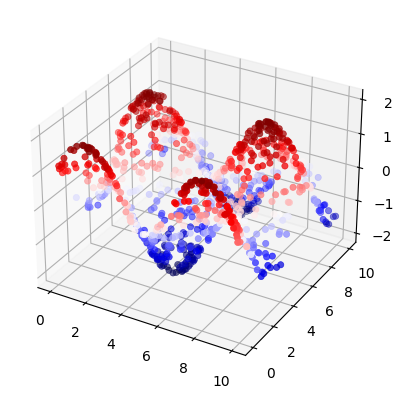

Loss epoch 0 : 1.5199576017561136
Loss epoch 1000 : 0.7592390060217847
Loss epoch 2000 : 0.6579959539249832
Loss epoch 3000 : 0.5897192557061455
Loss epoch 4000 : 0.5136296992466606
Loss epoch 5000 : 0.43094119156041755
Loss epoch 6000 : 0.3765956072580582
Loss epoch 7000 : 0.3367748141715678
Loss epoch 8000 : 0.30002491517623486
Loss epoch 9000 : 0.27746655450717594
El r^2 de train es 0.7548204808880437
El r^2 de test es 0.6552917819273791


'PARA HACER ESTE EJERCICIO, FUE NECESARIO MODIFICAR LA FUNCIÓN DE LOSS, LAS DERIVADAS PARCIALES.TAMBIÉN SE BAJÓ EL LEARNING RATE DE 1 A 0.01 PARA QUE DE UN BUEN RESULTADO. COMO MEDIDA DE RENDIMIENTO SE USA R^2'

In [60]:
iniciar(numero_ejemplos=1000, graficar_datos=True, N_epochs_ej3=100, tolerancia_ej3=20)

'''PARA HACER ESTE EJERCICIO, FUE NECESARIO MODIFICAR LA FUNCIÓN DE LOSS, LAS DERIVADAS PARCIALES.TAMBIÉN SE BAJÓ EL LEARNING RATE DE 1 A 0.01 PARA QUE DE UN BUEN RESULTADO. COMO MEDIDA DE RENDIMIENTO SE USA R^2'''